# NBA Clutch Time Efficiency Analysis

### 1. Introduction 👋
Late-game moments in basketball can define careers. These "clutch" situations—typically the final five minutes of a close game—are where players are expected to deliver under intense pressure, often with the outcome of the game hanging in the balance. While some athletes earn reputations for being clutch, it remains unclear whether such performance is truly consistent or driven more by perception, anecdotal highlights, and media narratives. Despite its importance in both fan culture and front office decision-making, clutch performance remains a difficult trait to quantify or predict. This project investigates the relationship between regular season performance metrics and clutch-time field goal percentage (FG%) in the NBA. By leveraging two decades of historical data and applying machine learning techniques, our research explores whether certain patterns or indicators in a player’s regular season statistics can help identify those most likely to excel in high-stakes moments. Ultimately, we aim to understand whether “being clutch” is a measurable skill or a statistical illusion.

In [3]:
# imports all needed packages 📚
from nba_api.stats.endpoints import LeagueDashPlayerStats, LeagueDashPlayerClutch
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import shap
from sklearn.inspection import PartialDependenceDisplay

# 2. Data Retrieval 📁

All data for this project comes from the [NBA's website](https://www.nba.com/) using the [nba_api](https://github.com/swar/nba_api) package.  Regular and clutch play statistics for every regular season game between 2000 and 2024 are collected and merged onto a singular dataset.

The below code block contains the code that performs the data collecting, but if you would prefer to avoid running it to save time, there is a csv file provided on the [project's repository page](https://github.com/fredam2025/nbaclutch?tab=readme-ov-file) that you can download and use in a specific code block further down.

In [5]:
# define get_regular_stats func
def get_regular_stats(season):
    # retrieve the regular play stats from the selected season
    regular_stats = LeagueDashPlayerStats(season=season, season_type_all_star="Regular Season")
    # construct a pandas dataframe using the retrieved regular stats
    df = regular_stats.get_data_frames()[0]
    # create a new column for the selected season
    df["SEASON"] = season
    # return the stats dataframe
    return df

# define get_clutch_stats func
def get_clutch_stats(season):
    # retrieve the clutch play stats from the selected season, with clutch time defined as last 5 minutes ahead/behind and 5 point differential
    clutch_stats = LeagueDashPlayerClutch(
        season=season,
        season_type_all_star="Regular Season",
        clutch_time="Last 5 Minutes",
        ahead_behind="Ahead or Behind",
        point_diff="5"
    )
    # construct a pandas dataframe using the retrieved clutch stats
    df = clutch_stats.get_data_frames()[0]
    # create a new column for the selected season
    df["SEASON"] = season
    # return the stats dataframe
    return df

# select seasons to analyze (2000 thru 2024)
seasons = [f"{year}-{str(year+1)[-2:]}" for year in range(2000, 2024)]
# initialize lists for all the regular and clutch dataframes
all_regular, all_clutch = [], []

# iterate through each season
for season in seasons:
    # use a try statement for obtaining each season's data
    try:
        # print the season year for which data is being collected
        print(f"Getting data for {season}...")
        # retrieve the regular play stats from the selected season
        regular_df = get_regular_stats(season)
        # retrieve the clutch play stats from the selected season
        clutch_df = get_clutch_stats(season)

        # append the current season's regular stats to the overall regular stats list
        all_regular.append(regular_df)
        # append the current season's regular stats to the overall clutch stats list
        all_clutch.append(clutch_df)

        # sleep for 1.5 seconds to prevent API lockout
        time.sleep(1.5)
    # catch exceptions
    except Exception as e:
        # print exception for the given season if any errors occur
        print(f"Failed for {season}: {e}")

# combine the regular stats in the all_regular list
df_regular = pd.concat(all_regular, ignore_index=True)
# combine the clutch stats in the all_clutch list
df_clutch = pd.concat(all_clutch, ignore_index=True)

# combine regular and clutch stats
df_clutchreg = pd.merge(
    df_regular,
    df_clutch,
    on=["PLAYER_ID", "SEASON"],
    suffixes=("_overall", "_clutch")
)

Getting data for 2000-01...
Getting data for 2001-02...
Getting data for 2002-03...
Getting data for 2003-04...
Getting data for 2004-05...
Getting data for 2005-06...
Getting data for 2006-07...
Getting data for 2007-08...
Getting data for 2008-09...
Getting data for 2009-10...
Getting data for 2010-11...
Getting data for 2011-12...
Getting data for 2012-13...
Getting data for 2013-14...
Getting data for 2014-15...
Getting data for 2015-16...
Getting data for 2016-17...
Getting data for 2017-18...
Getting data for 2018-19...
Getting data for 2019-20...
Getting data for 2020-21...
Getting data for 2021-22...
Getting data for 2022-23...
Getting data for 2023-24...


In [6]:
# saves the combined regular and clutch stats dataframe as a CSV file in your current working directory
# df_clutchreg.to_csv('clutchreg_stats.csv', index=False)

# this will be commented out as the csv file is provided in the project repository at https://github.com/fredam2025/nbaclutch

📌 This process allows us to collect all of the regular and clutch play stats for the selected seasons we are analyzing.

In [72]:
# set display settings to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
# prevents pandas from columns short
pd.set_option('display.max_colwidth', None)

In [64]:
# loads the pandas dataframe for regular and clutch play stats obtained from running the code above
# df_clutchreg = pd.read_csv(r"C:\Users\micha\Downloads\googlereviews.csv")

# this will be commented by default, but if you opted to use the csv file provided on the project repository's page rather than the data collection
# functions above, you can put the file path to the line of code above and un-comment the line

In [80]:
# print the number of columns within the dataframe
num_columns = df_clutchreg.shape[1]
# print out the columns within the dataframe
print(f"Number of columns: {num_columns}")
print(df_clutchreg.columns)

Number of columns: 133
Index(['PLAYER_ID', 'PLAYER_NAME_overall', 'NICKNAME_overall',
       'TEAM_ID_overall', 'TEAM_ABBREVIATION_overall', 'AGE_overall',
       'GP_overall', 'W_overall', 'L_overall', 'W_PCT_overall',
       ...
       'BLK_RANK_clutch', 'BLKA_RANK_clutch', 'PF_RANK_clutch',
       'PFD_RANK_clutch', 'PTS_RANK_clutch', 'PLUS_MINUS_RANK_clutch',
       'NBA_FANTASY_PTS_RANK_clutch', 'DD2_RANK_clutch', 'TD3_RANK_clutch',
       'WNBA_FANTASY_PTS_RANK_clutch'],
      dtype='object', length=133)


In [76]:
# print the first five players' stats within the df_clutchreg dataframe
df_clutchreg.head()

,PLAYER_ID,PLAYER_NAME_overall,NICKNAME_overall,TEAM_ID_overall,TEAM_ABBREVIATION_overall,AGE_overall,GP_overall,W_overall,L_overall,W_PCT_overall,MIN_overall,FGM_overall,FGA_overall,FG_PCT_overall,FG3M_overall,FG3A_overall,FG3_PCT_overall,FTM_overall,FTA_overall,FT_PCT_overall,OREB_overall,DREB_overall,REB_overall,AST_overall,TOV_overall,STL_overall,BLK_overall,BLKA_overall,PF_overall,PFD_overall,PTS_overall,PLUS_MINUS_overall,NBA_FANTASY_PTS_overall,DD2_overall,TD3_overall,WNBA_FANTASY_PTS_overall,GP_RANK_overall,W_RANK_overall,L_RANK_overall,W_PCT_RANK_overall,MIN_RANK_overall,FGM_RANK_overall,FGA_RANK_overall,FG_PCT_RANK_overall,FG3M_RANK_overall,FG3A_RANK_overall,FG3_PCT_RANK_overall,FTM_RANK_overall,FTA_RANK_overall,FT_PCT_RANK_overall,OREB_RANK_overall,DREB_RANK_overall,REB_RANK_overall,AST_RANK_overall,TOV_RANK_overall,STL_RANK_overall,BLK_RANK_overall,BLKA_RANK_overall,PF_RANK_overall,PFD_RANK_overall,PTS_RANK_overall,PLUS_MINUS_RANK_overall,NBA_FANTASY_PTS_RANK_overall,DD2_RANK_overall,TD3_RANK_overall,WNBA_FANTASY_PTS_RANK_overall,SEASON,GROUP_SET,PLAYER_NAME_clutch,NICKNAME_clutch,TEAM_ID_clutch,TEAM_ABBREVIATION_clutch,AGE_clutch,GP_clutch,W_clutch,L_clutch,W_PCT_clutch,MIN_clutch,FGM_clutch,FGA_clutch,FG_PCT_clutch,FG3M_clutch,FG3A_clutch,FG3_PCT_clutch,FTM_clutch,FTA_clutch,FT_PCT_clutch,OREB_clutch,DREB_clutch,REB_clutch,AST_clutch,TOV_clutch,STL_clutch,BLK_clutch,BLKA_clutch,PF_clutch,PFD_clutch,PTS_clutch,PLUS_MINUS_clutch,NBA_FANTASY_PTS_clutch,DD2_clutch,TD3_clutch,WNBA_FANTASY_PTS_clutch,GP_RANK_clutch,W_RANK_clutch,L_RANK_clutch,W_PCT_RANK_clutch,MIN_RANK_clutch,FGM_RANK_clutch,FGA_RANK_clutch,FG_PCT_RANK_clutch,FG3M_RANK_clutch,FG3A_RANK_clutch,FG3_PCT_RANK_clutch,FTM_RANK_clutch,FTA_RANK_clutch,FT_PCT_RANK_clutch,OREB_RANK_clutch,DREB_RANK_clutch,REB_RANK_clutch,AST_RANK_clutch,TOV_RANK_clutch,STL_RANK_clutch,BLK_RANK_clutch,BLKA_RANK_clutch,PF_RANK_clutch,PFD_RANK_clutch,PTS_RANK_clutch,PLUS_MINUS_RANK_clutch,NBA_FANTASY_PTS_RANK_clutch,DD2_RANK_clutch,TD3_RANK_clutch,WNBA_FANTASY_PTS_RANK_clutch
0,920,A.C. Green,A.C.,1610612748,MIA,37.0,82,50,32,0.610,1411.818333,144,324,0.444,0,6,0.000,79,111,0.712,107,206,313,39,45,30,8,29,119,1,367,104,870.1,3,0,795.0,2,38,262,130,188,213,216,171,295,257,295,192,189,259,91,135,115,273,265,232,271,263,220,39,212,95,218,126,26,223,2000-01,Players,A.C. Green,A.C.,1610612748,MIA,37.0,13,9,4,0.692,16.295000,1,3,0.333,0,0,0.000,2,2,1.000,1,1,2,0,0,0,0,0,2,0,4,-1,6.4,1,0,6.0,234,178,87,36,279,271,276,222,147,227,147,233,255,1,202,290,285,269,273,244,185,1,90,13,278,187,312,140,13,307
1,2062,A.J. Guyton,A.J.,1610612741,CHI,23.0,33,6,27,0.182,628.538333,78,192,0.406,27,69,0.391,15,18,0.833,10,26,36,64,24,9,5,3,35,0,198,-145,355.2,0,0,353.0,334,381,204,419,297,291,285,293,137,147,62,343,358,71,353,360,361,221,326,336,311,57,92,112,292,378,317,224,26,314,2000-01,Players,A.J. Guyton,A.J.,1610612741,CHI,23.0,10,3,7,0.300,21.908333,0,6,0.000,0,1,0.000,2,2,1.000,1,0,1,4,0,0,0,1,2,0,2,-4,9.2,0,0,7.0,262,275,144,330,262,310,241,310,147,185,147,233,255,1,202,329,313,125,273,244,185,186,90,13,304,215,291,184,13,301
2,243,Aaron McKie,Aaron,1610612755,PHI,28.0,76,51,25,0.671,2390.726667,338,714,0.473,53,170,0.312,149,194,0.768,33,278,311,377,203,106,8,56,178,0,878,334,1955.7,8,2,1847.0,120,31,178,57,79,80,92,106,89,77,181,109,108,176,253,79,118,29,28,30,271,376,316,112,87,20,84,77,4,81,2000-01,Players,Aaron McKie,Aaron,1610612755,PHI,28.0,32,20,12,0.625,140.665000,19,52,0.365,7,21,0.333,14,18,0.778,1,13,14,11,13,0,0,4,20,0,59,26,79.3,3,1,91.0,102,59,227,72,59,48,48,198,18,16,62,84,89,150,202,84,118,43,12,244,185,334,356,13,56,47,96,99,6,76
3,1425,Aaron Williams,Aaron,1610612751,NJN,29.0,82,26,56,0.317,2334.001667,297,650,0.457,0,2,0.000,244,310,0.787,211,379,590,88,132,59,113,70,319,0,838,-381,2062.0,12,0,1860.0,2,223,427,358,90,105,109,141,295,313,295,51,53,146,18,44,34,181,91,122,24,404,441,112,91,434,77,53,26,79,2000-01,Players,Aaron Williams,Aaron,1610612751,NJN,29.0,36,13,23,0.361

# Data Preparation 🔨

In [13]:
# filter out players that have less than 30 clutch play minutes for the season and create a new dataframe using a copy of the df_clutchreg dataframe
filtered = df_clutchreg[df_clutchreg["MIN_clutch"] >= 30].copy()

# normalize points-per-minute rate data by dividing by minutes played
filtered["PTS_per_min_clutch"] = filtered["PTS_clutch"] / filtered["MIN_clutch"]
filtered["PTS_per_min_overall"] = filtered["PTS_overall"] / filtered["MIN_overall"]
# save the normalized points-per-minute rate delta as PTS_delta
filtered["PTS_per_min_delta"] = filtered["PTS_per_min_clutch"] - filtered["PTS_per_min_overall"]

# normalize fga-per-minute rate data by dividing by minutes played
filtered["FGA_per_min_clutch"] = filtered["FGA_clutch"] / filtered["MIN_clutch"]
filtered["FGA_per_min_overall"] = filtered["FGA_overall"] / filtered["MIN_overall"]
# save the normalized fga-per-minute rate delta as FGA_per_min_delta
filtered["FGA_per_min_delta"] = filtered["FGA_per_min_clutch"] - filtered["FGA_per_min_overall"]

# normalize ast-per-minute rate data by dividing by minutes played
filtered["AST_clutch_per_min"] = filtered["AST_clutch"] / filtered["MIN_clutch"]
filtered["AST_overall_per_min"] = filtered["AST_overall"] / filtered["MIN_overall"]
# save the normalized ast-per-minute rate delta as AST_delta
filtered["AST_per_min_delta"] = filtered["AST_clutch_per_min"] - filtered["AST_overall_per_min"]

# normalize tov-per-minute rate data by dividing by minutes played
filtered["TOV_clutch_per_min"] = filtered["TOV_clutch"] / filtered["MIN_clutch"]
filtered["TOV_overall_per_min"] = filtered["TOV_overall"] / filtered["MIN_overall"]
# save the normalized tov-per-minute rate delta as TOV_delta
filtered["TOV_per_min_delta"] = filtered["TOV_clutch_per_min"] - filtered["TOV_overall_per_min"]

# normalize pts-per-fga efficiency data by dividing pts by fga
filtered["PTS_per_FGA_clutch"] = filtered["PTS_clutch"] / filtered["FGA_clutch"]
filtered["PTS_per_FGA_overall"] = filtered["PTS_overall"] / filtered["FGA_overall"]
# save the normalized pts-per-fga efficiency effiency delta as PTS_per_FGA_delta
filtered["PTS_per_FGA_delta"] = filtered["PTS_per_FGA_clutch"] - filtered["PTS_per_FGA_overall"]

# save the fg-pct delta as FG_PCT_delta
filtered["FG_PCT_delta"] = filtered["FG_PCT_clutch"] - filtered["FG_PCT_overall"]

❗ Quick Distinction Between FGA_per_min_delta and FG_PCT_delta:
- FGA_per_min_delta: Do their shot attempts lead to more points in the clutch?
- FG_PCT_delta: Do they make more shots in the clutch?

📌 With a quick change, we can focus our filter on players with decent FGA volume and efficiency improvement.

In [16]:
# filter out players that have less than 20 attempted fields goals during clutch play
filtered = filtered[filtered["FGA_clutch"] >= 20]

In [17]:
# 🔥 Top efficient clutch-time risers
top_efficient_clutch = filtered.sort_values("PTS_per_FGA_delta", ascending=False)[
    [
        "PLAYER_NAME_overall", "SEASON", "MIN_clutch",
        "PTS_per_FGA_clutch", "PTS_per_FGA_overall", "PTS_per_FGA_delta"
    ]
].head(15)

print("\n💎 Top 15 *efficient* clutch-time risers (by PTS/FGA delta, MIN_clutch ≥ 30, FGA_clutch ≥ 20")
print(top_efficient_clutch)


💎 Top 15 *efficient* clutch-time risers (by PTS/FGA delta, MIN_clutch ≥ 30, FGA_clutch ≥ 20
     PLAYER_NAME_overall   SEASON  MIN_clutch  PTS_per_FGA_clutch  PTS_per_FGA_overall  PTS_per_FGA_delta
5197          Randy Foye  2012-13  109.386667            2.250000             1.195122           1.054878
2072    Damon Stoudamire  2005-06   56.001667            2.083333             1.104530           0.978804
5661        Shawn Marion  2013-14  128.978333            2.095238             1.117232           0.978006
47         Bryon Russell  2000-01  133.655000            2.275862             1.332857           0.943005
7091          Chris Paul  2017-18   55.198333            2.296296             1.354637           0.941660
6350          Jeremy Lin  2015-16  100.700000            2.178571             1.255495           0.923077
4217         Jodie Meeks  2010-11   85.745000            2.272727             1.357895           0.914833
4827          Tony Allen  2011-12   76.806667            2.

In [18]:
# ❌ Biggest clutch-time efficiency declines
bottom_efficient_clutch = filtered.sort_values("PTS_per_FGA_delta", ascending=True)[
    [
        "PLAYER_NAME_overall", "SEASON", "MIN_clutch",
        "PTS_per_FGA_clutch", "PTS_per_FGA_overall", "PTS_per_FGA_delta"
    ]
].head(15)

print("\n💎 Bottom 15 *efficient* clutch-time risers (by PTS/FGA delta, MIN_clutch ≥ 30, FGA_clutch ≥ 20")
print(bottom_efficient_clutch)


💎 Bottom 15 *efficient* clutch-time risers (by PTS/FGA delta, MIN_clutch ≥ 30, FGA_clutch ≥ 20
     PLAYER_NAME_overall   SEASON  MIN_clutch  PTS_per_FGA_clutch  PTS_per_FGA_overall  PTS_per_FGA_delta
8966       Devin Vassell  2021-22   92.038333            0.272727             1.141361          -0.868634
7593        Dion Waiters  2018-19   56.180000            0.250000             1.102510          -0.852510
5449          J.J. Barea  2013-14   48.280000            0.350000             1.006098          -0.656098
9493   Immanuel Quickley  2022-23  114.866667            0.636364             1.291667          -0.655303
3034        Kirk Hinrich  2007-08  107.690000            0.428571             1.081556          -0.652984
2007      Antoine Walker  2005-06   68.206667            0.461538             1.113586          -0.652047
4732     Michael Beasley  2011-12   37.776667            0.440000             1.088531          -0.648531
1731       Jameer Nelson  2004-05   57.971667           

# 3. Modeling  📁

In [20]:
feature_cols = [
    # normalized per-minute and efficiency stats
    "PTS_per_min_overall",
    "AST_overall_per_min",
    "TOV_overall_per_min",
    "FGA_per_min_clutch",
    "AST_clutch_per_min",
    "TOV_clutch_per_min",

    # field goal pct for overall, clutch, and delta
    "FG_PCT_overall",
    "FG_PCT_clutch",
    "FG_PCT_delta",

    # clutch plus-minus
    "PLUS_MINUS_clutch"
]

# set target variable as PTS_per_FGA_delta
target = "PTS_per_FGA_delta"

# double-check the data by removing rows with missing values in selected features or target
data = filtered.dropna(subset=feature_cols + [target])
X = data[feature_cols]
y = data[target]

# Utilize a 20/80 train/test ratio, where 80% of the data will be used for training with the remaining 20% being used for testing
# X represents the independent variables (feature_cols), y represents the target variable (PTS_per_FGA_delta)
# Sets random_state to 42, so we have a saved seed to reproduce the splitting of data into the training and testing portions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define a set of hyperparameters for tuning the Random Forest model
# n_estimators: testing two number of decisions trees in the Random Forest; 100 and 200
# max_depth: testing three values for maximum depth of each three; None, 10, and 20
# min_samples_split: testing two values for minimum number of samples required to split an internal node; 2 and 5
# min_samples_leaf: testing two values for minimum number of samples required to be in a leaf node; 1 and 2
# max_features: testing two values for number of features to consider when looking for the best split; sqrt and log2
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# initialize RandomForestRegressor instance using random_state=42, so we have a saved seed to reproduce the model's results
rf = RandomForestRegressor(random_state=42)

# perform search over the selected hyperparameters above, evaluates model using cross-validation for every combination of hyperparameters
# estimator: specifies model being tuned, rf (Random Forest) in this case
# param_grid: dictionary containing all hyperparameters and their possible values, param_grid (defined above) in this case
# cv: number of cross-validation folds, 5-fold cross-validation in this case
# n_jobs: informs GridSearchCV to utilize all available CPU cores for parallel processing, resulting in faster performance
# verbose: level of verbosity that determines how detailed the output is
# scoring: determines performance metric being optimized, neg_mean_squared_error (MSE) in this case
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'
)

# run the grid search on the training data
grid_search.fit(X_train, y_train)

# select the best-performing model from the grid search and print out the hyperparameters used
print(f"Best Hyperparameters: {grid_search.best_params_}")
best_rf = grid_search.best_estimator_

# use the best-performing model to predict the target variable (PTS_per_FGA_delta) for the testing set (X_test)
y_pred = best_rf.predict(X_test)

# performance metrics

# R² (Coefficient of Determination) metric: shows how well the model explains the variance in the target variable
# 1.0: Perfect prediction, 0.0: No better than mean prediction, Negative: Worse than predicting the mean
print(f"R^2 Score: {r2_score(y_test, y_pred):.3f}")

# RMSE (Root Mean Squared Error) metric: shows the average magnitude of prediction errors (using same units as the target variable)
# Lower RMSE = better
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.3f}")

# MSE (Mean Squared Error) metric: shows the average of the squared differences between predicted and actual values in regression model
# Lower MSE = better
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
R^2 Score: 0.576
RMSE: 0.167
MSE: 0.028


C:\Users\micha\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Visualization of Model Results

C:\Users\micha\AppData\Local\Temp\ipykernel_10452\1139251584.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_imp_df, palette="Blues_d")


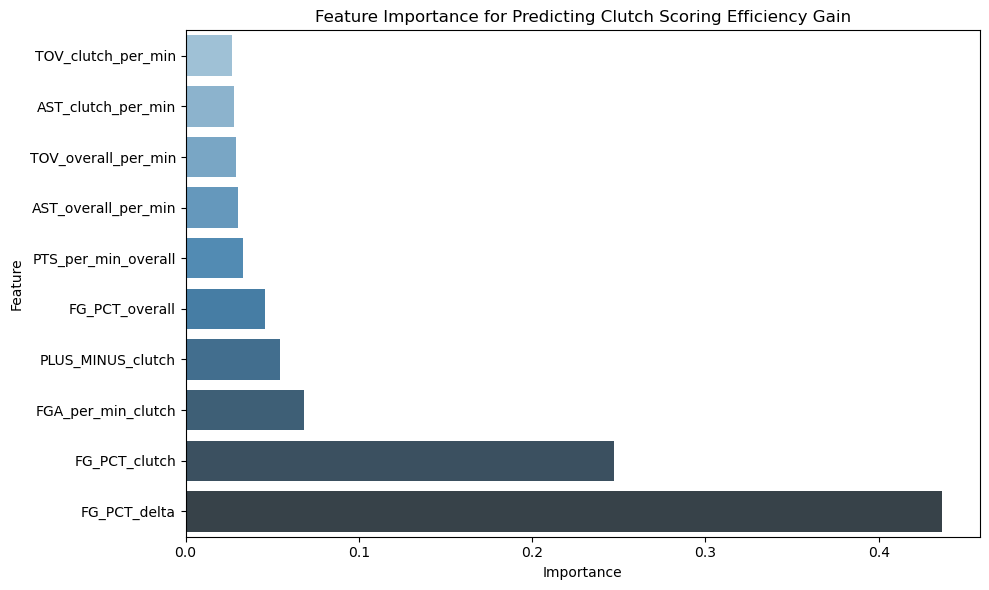

In [22]:
# feature importance plot

# obtain the importance score for each feature from the RF model
importances = best_rf.feature_importances_
# create a dataframe of feature-importance pairings
feature_imp_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values("Importance", ascending=True)

# create a horizontal bar plot using Seaborn to visualize the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_imp_df, palette="Blues_d")
plt.title("Feature Importance for Predicting Clutch Scoring Efficiency Gain")
plt.tight_layout()
plt.show()

📌 In this bar horizontal bar plot, we can see the most important feature for predicting clutch scoring effiency gain is FG_PCT_delta as it represents the change between field goal percentage between regular play and clutch play.  Following closely, FG_PCT_clutch is the second most important feature for predicting our target variable due to it showing how well the player shoots strictly in clutch play.  There are other features that contribute to the prediction, just not as impactful as the previously mentioned two features.

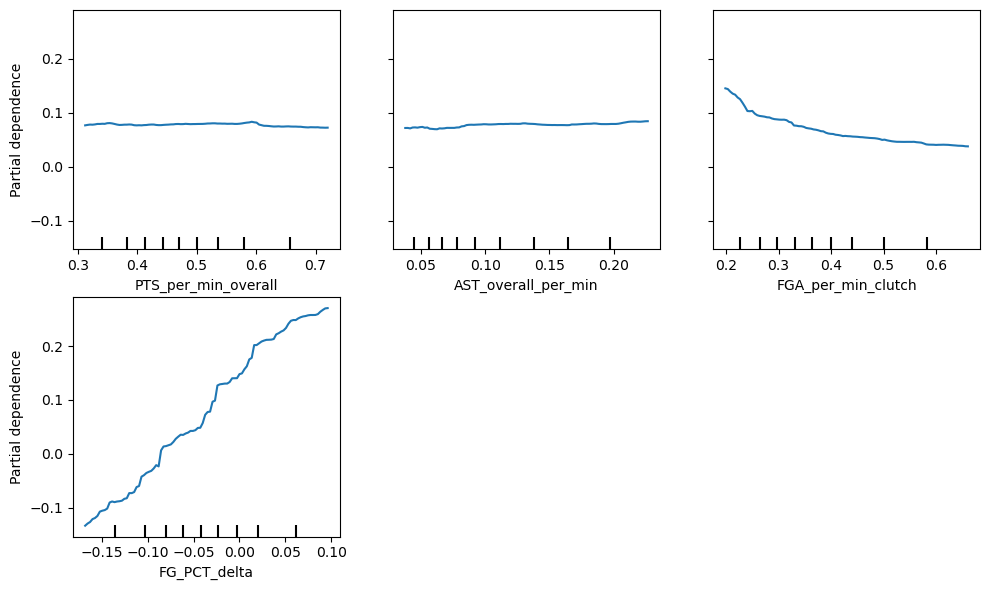

In [24]:
# partial dependence plot

# set up a figure and axis for plotting, along with the dimensions of the plot
fig, ax = plt.subplots(figsize=(10, 6))
# shows how changing each feature (with others remaining constant) influences the target variable (PTS_per_FGA_delta)
PartialDependenceDisplay.from_estimator(
    best_rf, X_train,
    features=[0, 1, 3, 8],  # Pick any meaningful indices to visualize
    feature_names=feature_cols,
    ax=ax
)
plt.tight_layout()
plt.show()

📌 This plot focuses on the relationship between a specific feature and the predicted target variable.  With this in mind, we can the PTS_per_min_overall and AST_overall_per_min features have no significant impact on the predicted PTS_per_FGA_delta.  The FGA_per_min_clutch displays a slightly negative relationship, but it is not too impactful as it follows a very steep curve.  However, the FG_PCT_delta feature seems to have a positive linear relationship with our target variable, meaning as FG_PCT_delta goes up, FGA_per_min_clutch goes up.  This means that PTS_per_min_overall serves as a good predictor for our target variable.

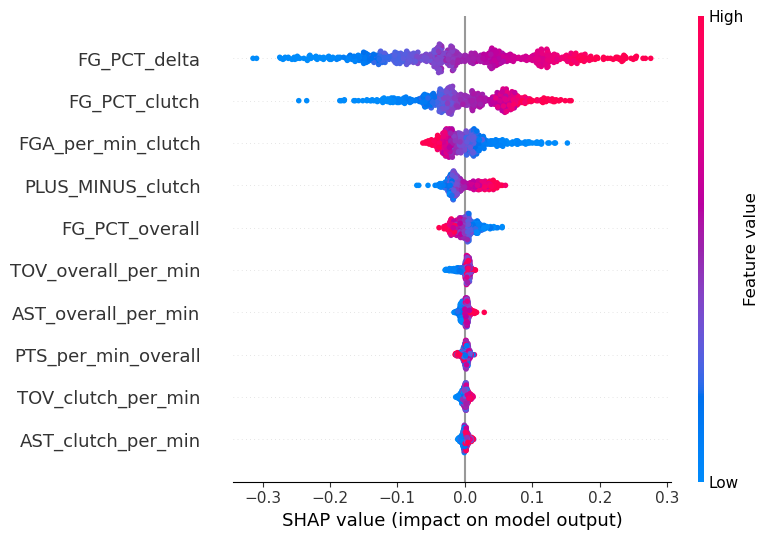

In [26]:
# SHAP summary plot

# initialize a SHAP explainer that explains the predictions of the model by calculating how much each feature contributes to the target variable prediction
explainer = shap.TreeExplainer(best_rf)
# calculate SHAP values (how much each feature pushed the prediction up or down compared to model's average prediction) for all the samples in the testing set
shap_values = explainer.shap_values(X_test)
# plot summary showing variability in feature impact across samples
shap.summary_plot(shap_values, X_test, feature_names=feature_cols)

📌 This plot interprets the importance and effects of each feature in the Random Forest Regression Model.  For the y-axis, blue represents the lower values of the feature, while red represents the higher values of the feature.  So if we had a min FG_PCT_clutch of 0% and a max FG_PCT_clutch of 40%, a feature value of 10% would be blue, while a feature value of 30% would be red.  For the x-axis, the SHAP value represents if the feature pushed the prediction higher (positive SHAP value) or lower (negative SHAP value).  Looking at the plot, we can see that the FG_PCT_delta and FG_PCT_clutch features pushed the prediction higher given higher values for each feature, while pushing the prediction lower given lower values for each feature.  Looking at FGA_per_min_clutch, we see the opposite of this as higher feature values resulted in pushing the prediction lower, and lower feature values pushed the prediction higher.

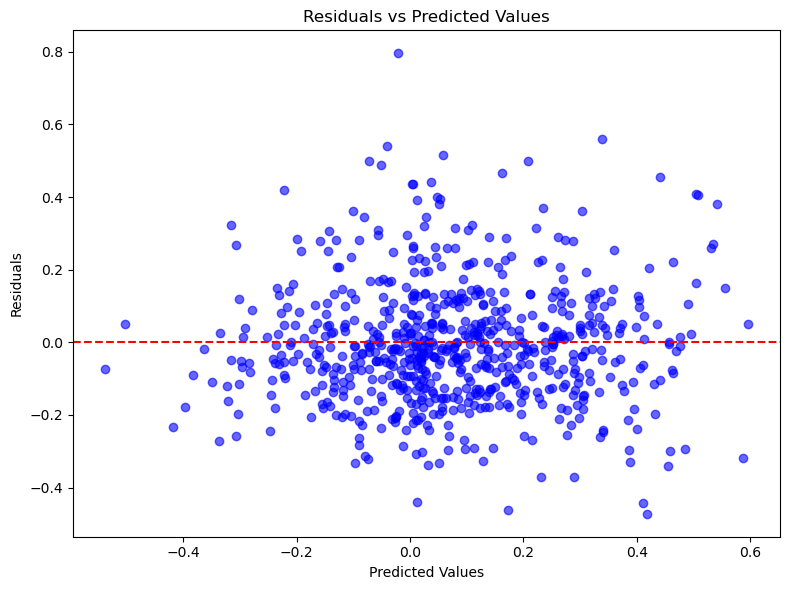

In [28]:
# residuals plot

# obtain the residuals (actual PTS_per_FGA_delta vs predicted PTS_per_FGA_delta)
residuals = y_test - y_pred
# set up plot showing the residuals to represent model performance
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.tight_layout()
plt.show()

📌 This plot assesses the quality of the regression model.  Looking at the plot, we can see we have a good residuals vs predicted plot as there is no pattern or trend, with a random distribution around zero and no concentration of values (no clustering/patterns).

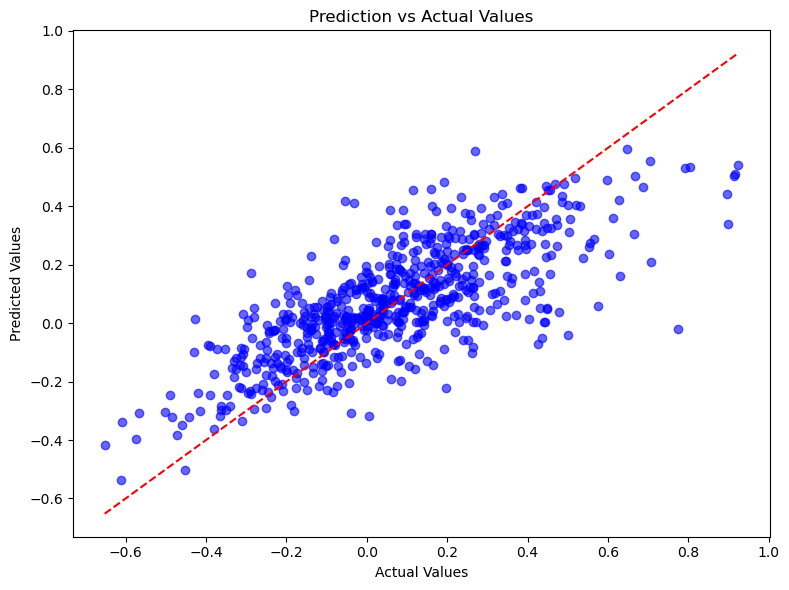

In [30]:
# prediction vs actual plot

# set up plot showing predicted values (by model) vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs Actual Values")
plt.tight_layout()
plt.show()

📌 This plot visualizes the relationship between the model's predicted values and the actual values from the dataset.  This helps to assess how well the model performs in terms of prediction accuracy.  Looking at the plot, we can see our results are promising as most of the data points are closely aligned with the line of perfect fit with minimum deviation from the line.

# Conclusion 🏁

Looking at our results, we can see that our model highlighted FG_PCT_delta as the most important feature for predicting our target variable, with FG_PCT_clutch following behind as second most important.  This continues to be represented in our SHAP summary plot as these same two features are expressed as the most impactful to our model's prediction.  These results indicate that PTS_per_FGA_delta can be best predicted by using these two predictors.

In terms of our Random Forest Model, it explained over 57% of the variation in PTS_per_FGA delta, meaning that while it may not be perfect in terms of predicting clutch performance, it definitely is effective in giving insights about what leads to changes in scoring effiency in clutch play.  These implications can be used by coaches and analysts to optimize late-game strategy and hidden talent within their current teams.  Scouts can utilize these results along with their own traditional evaluations to make better-informed decisions.  In terms of the most important people, the fans, the findings can challenge established narratives of what makes a player "clutch", reflected by the media.

It is important to keep in mind that using predictive models such as this model, limitations always exist.  In this case, this involves ignoring psychological factors like confidence or pressure.  In addition to this, judging a player by numbers alone could leave out important characteristics such as the player's role on the team such as leadership, along with other context that impact a player's value.